# Module 12: Maps

Let's draw some maps. 🗺🧐

Due to some issues with Bokeh vs. Jupyter Lab, please use Jupyter notebook for the later part. Make sure you have the most recent version of everything: https://altair-viz.github.io/getting_started/installation.html#quick-start-altair-notebook and have the vega nbextension: https://github.com/vega/ipyvega#install-and-run

Notes:

1. If Altair gives errors such as `Javascript error: unable to ...`, it is possibly due to the browser blocking certain Javascript features. Changing to another browser may solve this problem. Example: if you use Chrome, you may want to use Safari instead.

2. If you use Jupyter notebook, you need to add this line:

`alt.renderers.enable('notebook')`

However, if you use Jupyter lab, do **not** run this line.

## A dotmap with Altair

Let's start with altair. 

In [2]:
import altair as alt

# saving data into a file rather than embedding into the chart
alt.data_transformers.enable('json') 

# jupyter notebook needs this option.
# alt.renderers.enable('notebook')

DataTransformerRegistry.enable('json')

### A data cleaning lesson

Maybe we need a dataset with geographical coordinates. This `zipcodes` dataset contains the location and zipcode of each zip code area. 

In [3]:
from vega_datasets import data

zipcodes_url = data.zipcodes.url
zipcodes = data.zipcodes()
zipcodes.head()

zip_code   latitude  longitude        city state     county
0       501  40.922326 -72.637078  Holtsville    NY    Suffolk
1       544  40.922326 -72.637078  Holtsville    NY    Suffolk
2       601  18.165273 -66.722583    Adjuntas    PR   Adjuntas
3       602  18.393103 -67.180953      Aguada    PR     Aguada
4       603  18.455913 -67.145780   Aguadilla    PR  Aguadilla

There is a critical issue with this data. Can you spot it? ZIP codes are supposed to be 5 digits right? But why do they have only three digits? Let's sample more rows. 

In [3]:
zipcodes.sample(5)

zip_code   latitude   longitude            city state     county
13677     32341  30.477560  -83.391393         Madison    FL    Madison
12995     30705  34.785543  -84.771623      Chatsworth    GA     Murray
41131     98082  47.432251 -121.803388         Bothell    WA  Snohomish
5379      14754  42.031872  -78.209708  Little Genesee    NY   Allegany
17471     40935  36.871254  -83.829985       Flat Lick    KY       Knox

Ok, some have five digits but some have fewer. Let's check the dtype. 

In [4]:
zipcodes.zip_code.dtype

dtype('int64')

Ah, they are stored as integer! I know that there are zipcodes starting with '0', so they must have been chopped off. Let's load the data again, this time by specifying the correct dtype. 

In [5]:
zipcodes = data.zipcodes(dtype={'zip_code': 'category'})
zipcodes.head()

zip_code   latitude  longitude        city state     county
0    00501  40.922326 -72.637078  Holtsville    NY    Suffolk
1    00544  40.922326 -72.637078  Holtsville    NY    Suffolk
2    00601  18.165273 -66.722583    Adjuntas    PR   Adjuntas
3    00602  18.393103 -67.180953      Aguada    PR     Aguada
4    00603  18.455913 -67.145780   Aguadilla    PR  Aguadilla

Indeed! 

In [6]:
zipcodes.zip_code.dtype

CategoricalDtype(categories=['00501', '00544', '00601', '00602', '00603', '00604',
                  '00605', '00606', '00610', '00611',
                  ...
                  '99919', '99921', '99922', '99923', '99925', '99926',
                  '99927', '99928', '99929', '99950'],
                 ordered=False)

In [7]:
zipcodes.zip_code.apply(len).value_counts()

5    42049
Name: zip_code, dtype: int64

Yes, they all have five digits now. I think this is a useful reminder about the importance of being aware of data types, and being critical about your data. (btw, I've [reported this](https://github.com/altair-viz/vega_datasets/issues/16)). 

Btw, you'll have fewer issues if you pass URL instead of a dataframe to `alt.Chart`. 

### Let's draw it

Now we have the dataset loaded and start drawing some plots. Let's say you don't know anything about map projections. What would you try with geographical data? The simplest thing is probably considering (longitude, latitude) as a Cartesian coordinate and directly plot them. 

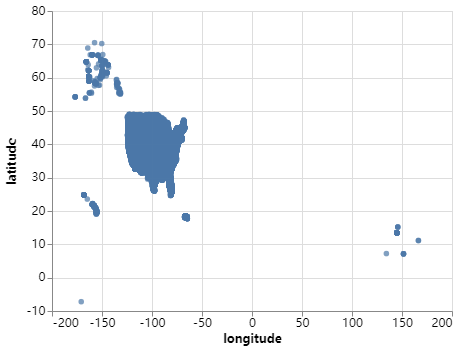

In [8]:
alt.Chart(zipcodes_url).mark_circle().encode(
    x='longitude:Q',
    y='latitude:Q',
)

Actually this itself is a map projection called [Equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). This projection (or almost a *non-projection*) is super straight-forward and doesn't require any processing of the data. So, often it is used to just quickly explore geographical data. As you dig deeper, you still want to think about which map projection fits your need best. Don't just use equirectangular projection without any thoughts! 

Anyway, let's make it look slighly better by reducing the size of the circles and adjusting the aspect ratio. 

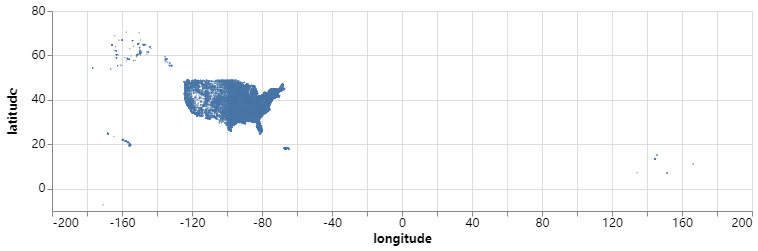

In [9]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    x='longitude:Q',
    y='latitude:Q',
).properties(
    width=700,
    height=200,
)

But, a much better way to do this is explicitly specifying that they are lat, lng coordinates by using `longitude=` and `latitude=`, rather than `x=` and `y=`. If you do that, altair automatically adjust the aspect ratio. Try to change the width and height. 

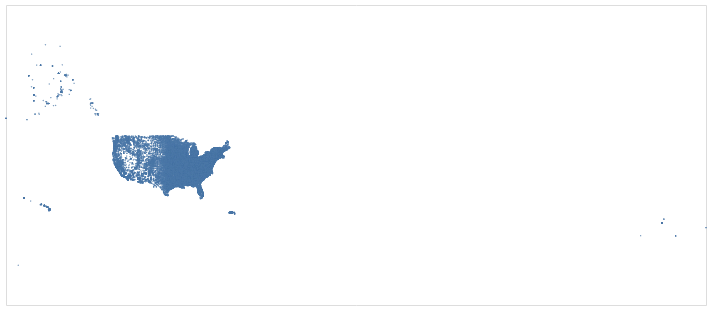

In [10]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).properties(
    width=700,
    height=300,
)

Because the [American empire is far-reaching and complicated](https://www.youtube.com/watch?v=ASSOQDQvVLU), the information density of this map is very low (although interesting). A common projection for visualizing US data is [AlbersUSA](https://bl.ocks.org/mbostock/5545680), which uses [Albers (equal-area) projection](https://en.wikipedia.org/wiki/Albers_projection). This is a standard projection used in United States Geological Survey and the United States Census Bureau. Albers USA is simply a composition of US main land, Alaska, and Hawaii. 

To use it, we simply call `project` method and specify which variables are `longitude` and `latitude`. 

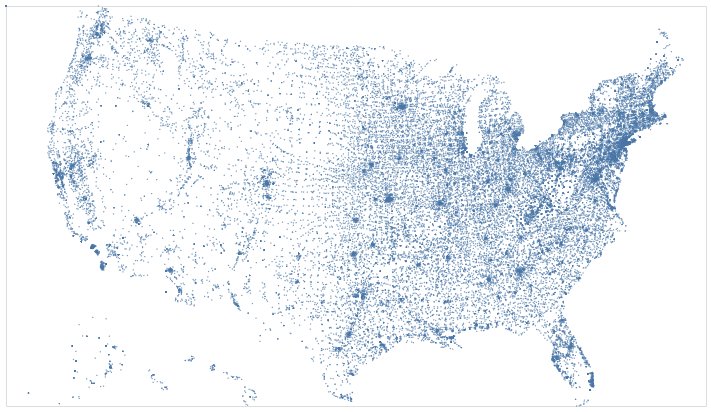

In [11]:
alt.Chart(zipcodes_url).mark_circle(size=2).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

Can we see the large-scale division of the zipcodes? We can use the fact that the zipcodes are hierarchically organized. That is, the first digit captures the largest area divisions. 

Altair provides some data transformation functionalities. One of them is extracting a substring from a variable. 

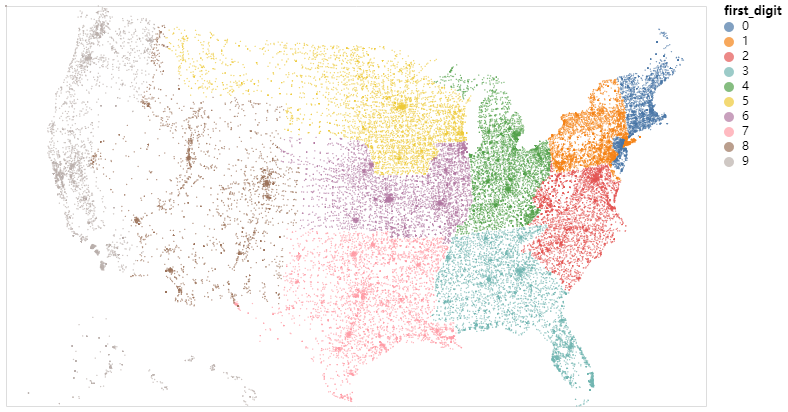

In [12]:
from altair.expr import datum, substring

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'first_digit', substring(datum.zip_code, 0, 1)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='first_digit:N',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

For each row (`datum`), you obtain the `zip_code` variable and get the substring (imagine Python list slicing), and then you call the result `first_digit`. Now, you can use this `first_digit` variable to color the circles. Also note that we specify `first_digit` as a *nominal* variable, not quantitative, to obtain a categorical colormap. But we can also play with it too. 

**Q: Why don't you extract the first two digits, name it as `two_digits`, and declare that as a quantitative variable? Any interesting patterns?** 

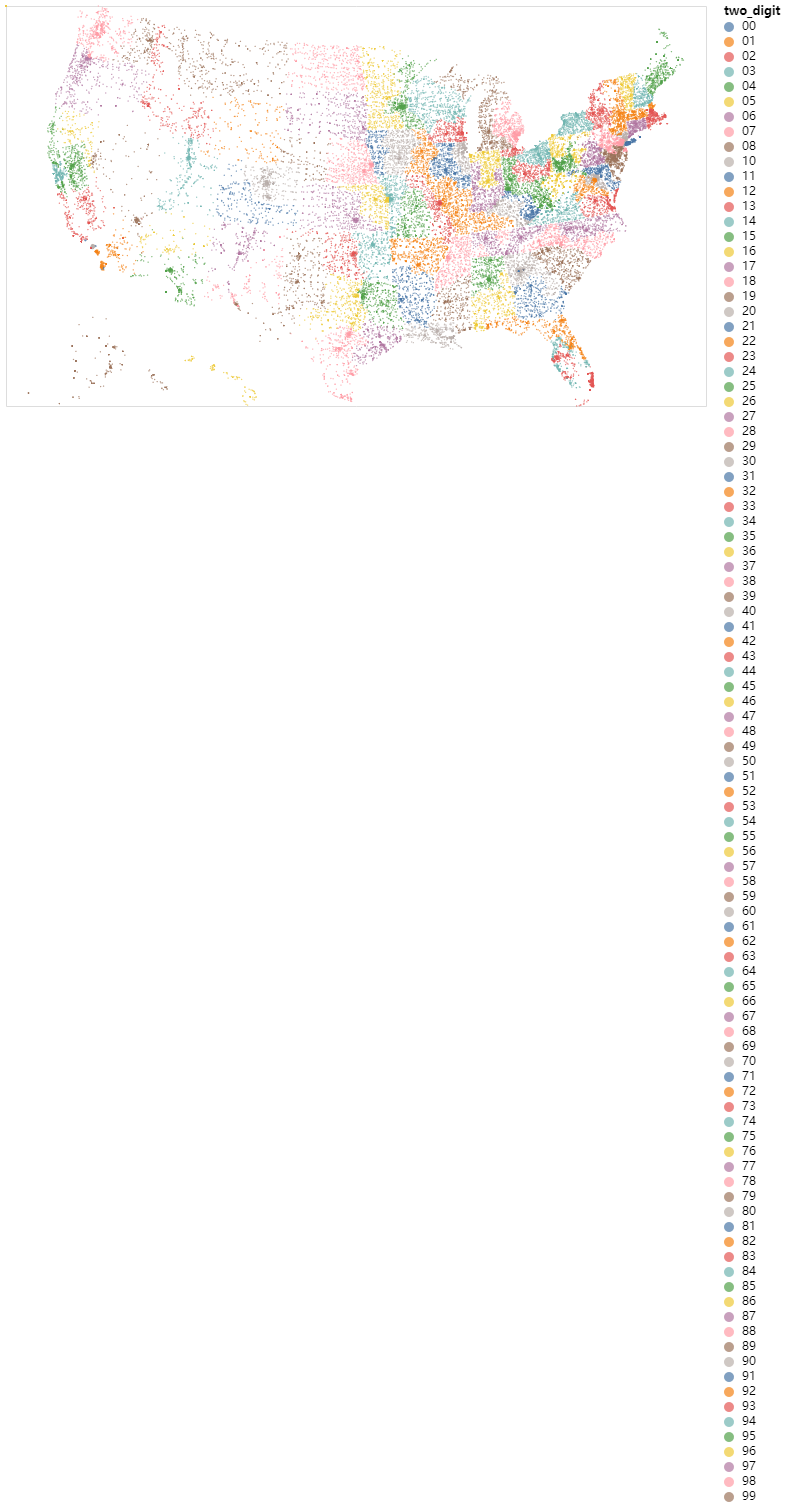

In [13]:
# Implement
from altair.expr import datum, substring

alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'two_digit', substring(datum.zip_code, 0, 2)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='two_digit:N',
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

Btw, we can also put a tooltip. Also, you can always click "view source" or "open in Vega Editor" to look at the json object that **defines** this visualization. You can embed this json object on your webpage and easily put up an interactive visualization. 

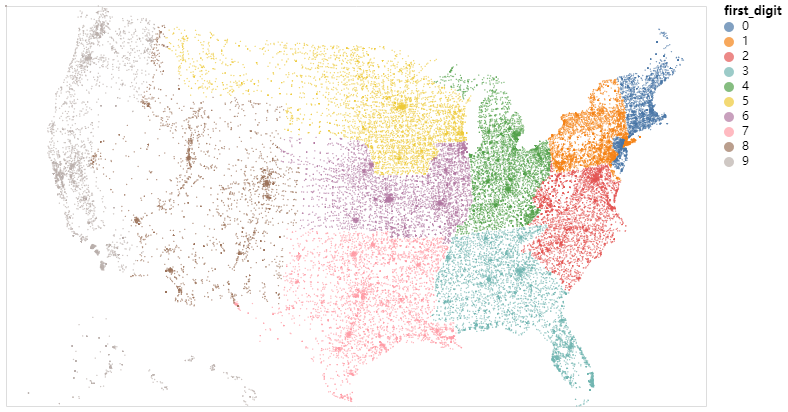

In [14]:
alt.Chart(zipcodes_url).mark_circle(size=2).transform_calculate(
    'first_digit', substring(datum.zip_code, 0, 1)
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='first_digit:N',
    tooltip='zip_code:N'
).project(
    type='albersUsa'
).properties(
    width=700,
    height=400,
)

## Choropleth 

Let's try some choropleth now. Vega datasets have US county / state boundary data (`us_10m`) and world country boundary data (`world-110m`). You can take a look at the boundaries on GitHub (they renders topoJSON files):

- https://github.com/vega/vega-datasets/blob/gh-pages/data/us-10m.json
- https://github.com/vega/vega-datasets/blob/gh-pages/data/world-110m.json

If you click "Raw" then you can take a look at the actual file, which is hard to read. 

Essentially, each file is a large dictionary with the following keys. 

In [15]:
usmap = data.us_10m()
usmap.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [16]:
usmap['type']

'Topology'

In [17]:
usmap['transform']

{'scale': [0.003589294092944858, 0.0005371535195261037],
 'translate': [-179.1473400003406, 17.67439566600018]}

This `transformation` is used to *quantize* the data and store the coordinates in integer (easier to store than float type numbers). 

https://github.com/topojson/topojson-specification#212-transforms

In [18]:
usmap['objects'].keys()

dict_keys(['counties', 'states', 'land'])

This data contains not only county-level boundaries (objects) but also states and land boundaries. 

In [19]:
usmap['objects']['land']['type'], usmap['objects']['states']['type'], usmap['objects']['counties']['type']

('MultiPolygon', 'GeometryCollection', 'GeometryCollection')

`land` is a multipolygon (one object) and `states` and `counties` contains many geometrics (multipolygons) because there are many states (counties). We can look at a state as a set of arcs that define it. It's `id` captures the identity of the state and is the key to link to other datasets. 

In [20]:
state1 = usmap['objects']['states']['geometries'][1]
state1

{'type': 'MultiPolygon',
 'arcs': [[[10337]],
  [[10342]],
  [[10341]],
  [[10343]],
  [[10834, 10340]],
  [[10344]],
  [[10345]],
  [[10338]]],
 'id': 15}

The `arcs` referred here is defined in `usmap['arcs']`. 

In [21]:
usmap['arcs'][:10]

[[[15739, 57220], [0, 0]],
 [[15739, 57220], [29, 62], [47, -273]],
 [[15815, 57009], [-6, -86]],
 [[15809, 56923], [0, 0]],
 [[15809, 56923], [-36, -8], [6, -210], [32, 178]],
 [[15811, 56883], [9, -194], [44, -176], [-29, -151], [-24, -319]],
 [[15811, 56043], [-12, -216], [26, -171]],
 [[15825, 55656], [-2, 1]],
 [[15823, 55657], [-19, 10], [26, -424], [-26, -52]],
 [[15804, 55191], [-30, -72], [-47, -344]]]

It seems pretty daunting to work with this dataset, right? But fortunately people have already built tools to handle such data. 

In [22]:
states = alt.topo_feature(data.us_10m.url, 'states')

In [23]:
states

UrlData({
  format: TopoDataFormat({
    feature: 'states',
    type: 'topojson'
  }),
  url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
})

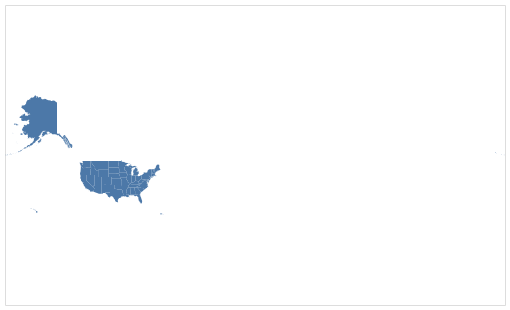

In [24]:
alt.Chart(states).mark_geoshape().properties(
    width=500,
    height=300
)

We have a map of US states. :) Can you use AlbersUSA projection on this? 

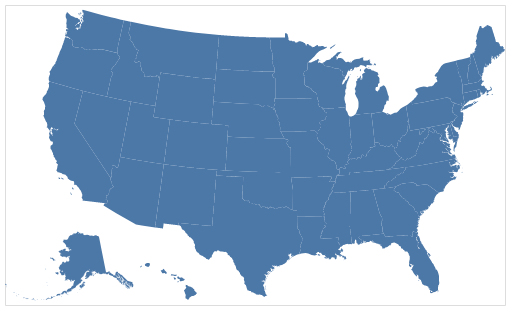

In [25]:
# Implement
alt.Chart(states).mark_geoshape().project(type='albersUsa').properties(
    width=500,
    height=300
)

Can you do the same thing with counties and draw county boundaries?

In [26]:
# Implement
us_counties = alt.topo_feature(data.us_10m.url, 'counties')

In [28]:
us_counties

UrlData({
  format: TopoDataFormat({
    feature: 'counties',
    type: 'topojson'
  }),
  url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
})

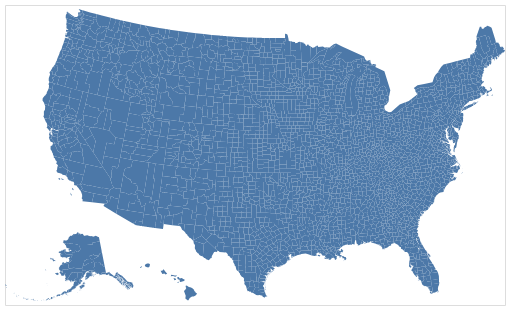

In [29]:
alt.Chart(us_counties).mark_geoshape().project(type='albersUsa').properties(
    width=500,
    height=300
)

Let's load some county-level unemployment data. 

In [30]:
unemp_data = data.unemployment(sep='\t')
unemp_data.head()

id   rate
0  1001  0.097
1  1003  0.091
2  1005  0.134
3  1007  0.121
4  1009  0.099

This dataset has unemployment rate. When? I don't know. We don't care about data provenance here because the goal is quickly trying out choropleth. But if you're working with a real dataset, you should be very sensitive about the provenance of your dataset. Make sure you understand where the data came from and how it was processed. 

Anyway, for each county specified with `id`. To combine two datasets, we use "Lookup transform" - https://vega.github.io/vega/docs/transforms/lookup/. Essentially, we use the `id` in the map data to look up (again) `id` field in the `unemp_data` and then bring in the `rate` variable. Then, we can use that `rate` variable to encode the color of the `geoshape` mark. 

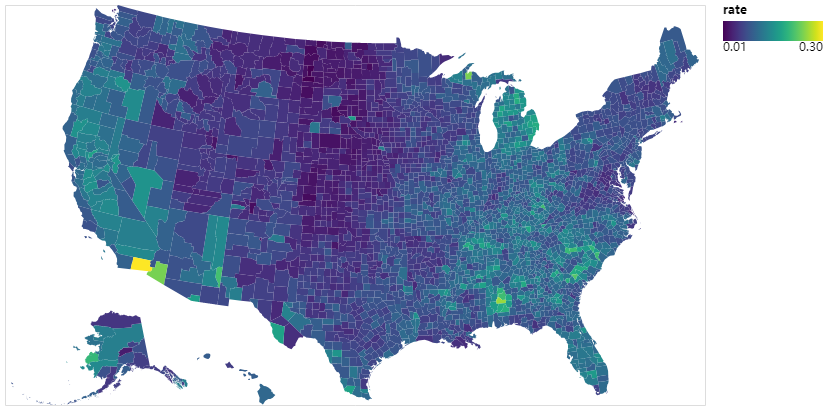

In [31]:
alt.Chart(us_counties).mark_geoshape().project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(unemp_data, 'id', ['rate'])
).encode(
    color='rate:Q'
).properties(
    width=700,
    height=400
)

There you have it, a basic choropleth map. 😎 


## Raster visualization with datashader

Although many geovisualizations use vector graphics, raster visualization is still useful especially when you deal with images and lots of datapoints. Datashader is a package that aggregates and visualizes a large amount of data very quickly. Given a *scene* (visualization boundary, resolution, etc.), it quickly aggregate the data and produce **pixels** and send them to you. 

To appreciate its power, we need a fairly large dataset. Let's use NYC taxi trip dataset on Kaggle: https://www.kaggle.com/kentonnlp/2014-new-york-city-taxi-trips You can download even bigger trip data from NYC open data website: https://opendata.cityofnewyork.us/data/

Ah, and you want to install the datashader, bokeh, and holoviews first if you don't have them yet.  

    pip install datashader bokeh holoviews

or 

    conda install datashader bokeh holoviews
    

In [6]:
import pandas as pd
import datashader as ds
from datashader import transfer_functions as tf
from colorcet import fire

Because the dataset is pretty big, let's use a small sample first (`nrows=10000`). For this visualization, we only keep the dropoff location. 

In [7]:
nyctaxi = pd.read_csv('~/Downloads/nyc_taxi_data_2014.csv', 
                      nrows=10000, 
                      usecols=['dropoff_longitude', 'dropoff_latitude'])
nyctaxi.head()

dropoff_longitude  dropoff_latitude
0         -73.982227         40.731790
1         -73.960449         40.763995
2         -73.986626         40.765217
3         -73.979863         40.777050
4         -73.984367         40.720524

Although the dataset is different, we can still follow the example here: http://datashader.org/getting_started/1_Introduction.html

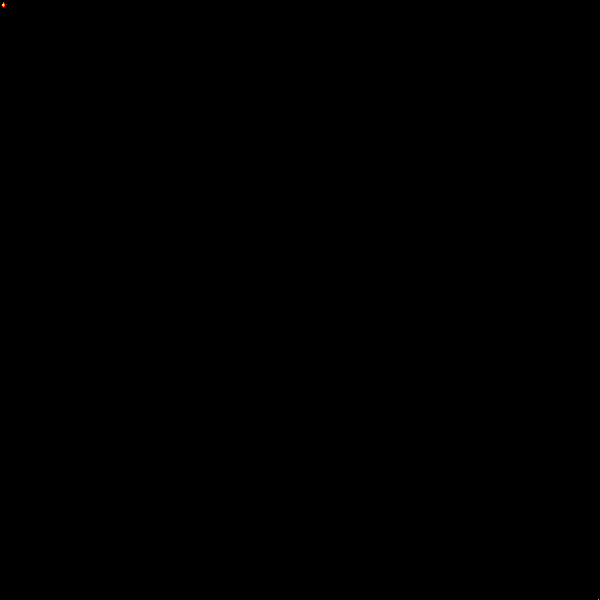

In [8]:
agg = ds.Canvas().points(nyctaxi, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

Why can't we see anything? Wait, do you see the small dots on the left top? Can that be New York City? Maybe we don't see anything because some people travel very far? or because the dataset has some missing data?

In [9]:
nyctaxi.isna().sum()

dropoff_longitude    1
dropoff_latitude     1
dtype: int64

In [10]:
nyctaxi.dropna(inplace=True)

Now there's no NaN in the data. let's try histogram. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189D1ED65C0>,
      dtype=object)

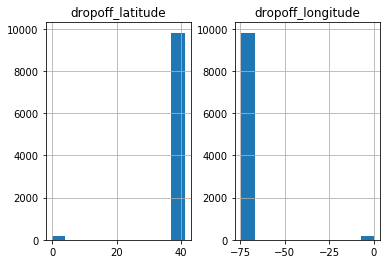

In [11]:
%matplotlib inline
nyctaxi.hist()

Ah, there seems to be some outliers, which look like zero. Because lat lng should vary within a very small range, let's filter the data.  

In [12]:
df = nyctaxi[nyctaxi['dropoff_latitude'].between(40.5, 41) & nyctaxi['dropoff_longitude'].between(-74.1, -73.7)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189D1FF67B8>,
      dtype=object)

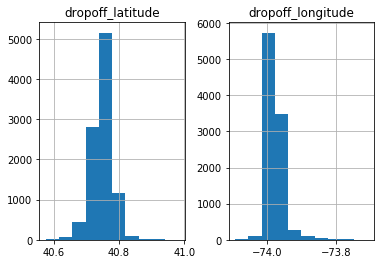

In [13]:
df.hist()

Now the histograms look pretty reasonable. 

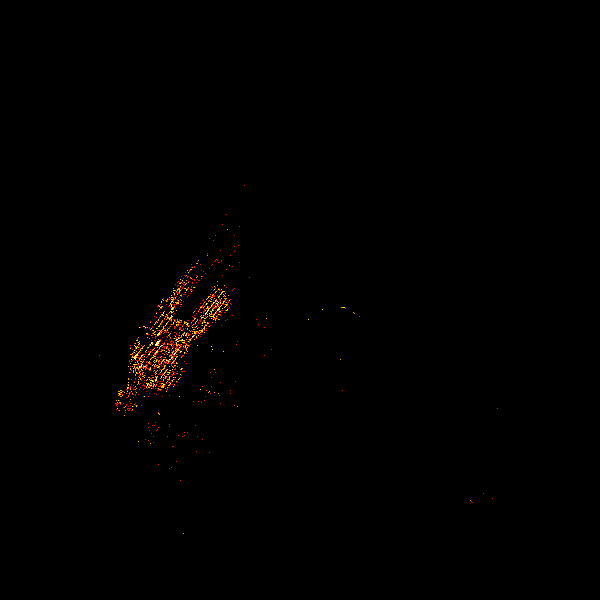

In [14]:
agg = ds.Canvas().points(df, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire), "black")

Do you see the black empty space at the center? That looks like the Central Park. This is cool, but it'll be awesome if we can explore the data interactively. 

Datashader can work with `holoviews` and `bokeh` libraries to enable some interactivity. See http://holoviews.org/gallery/apps/bokeh/nytaxi_hover.html#bokeh-gallery-nytaxi-hover But, we'll not try to reproduce this because it's a bit too much work, and because, at this moment, it's not easy to install `geoviews` and `cartopy`. Let's do a simpler version. First import the libraries and set it up to use bokeh, which is like a backend for drawing objects with javascript. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
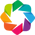

In [15]:
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

In [16]:
%%output size=200

points = hv.Points(df, ['dropoff_longitude', 'dropoff_latitude'])
taxi_trips = datashade(points, cmap=fire)
taxi_trips

:DynamicMap   []
   :RGB   [dropoff_longitude,dropoff_latitude]   (R,G,B,A)

Enable dragging (four-directional arrows) and wheel-zoom (a scroll wheel and a magnifying glass) on the right side of the figure and explore the data by dragging and zooming in and out. 

Pretty neat, right? 

Ok, now let's get serious by loading the whole dataset (it may take some time btw). Drop NaN rows, and filter using the latitude and longitude range that we used, and then feed the data into the datashader. 

In [17]:
# Implement 
nyctaxi_all = pd.read_csv('~/Downloads/nyc_taxi_data_2014.csv', 
                      usecols=['dropoff_longitude', 'dropoff_latitude'])
nyctaxi_all.head()

dropoff_longitude  dropoff_latitude
0         -73.982227         40.731790
1         -73.960449         40.763995
2         -73.986626         40.765217
3         -73.979863         40.777050
4         -73.984367         40.720524

In [24]:
df = nyctaxi_all[nyctaxi_all['dropoff_latitude'].between(40.5, 41) & nyctaxi_all['dropoff_longitude'].between(-74.1, -73.7)]

Can you feed the data directly to datashader to reproduce the static plot, this time with the full data?

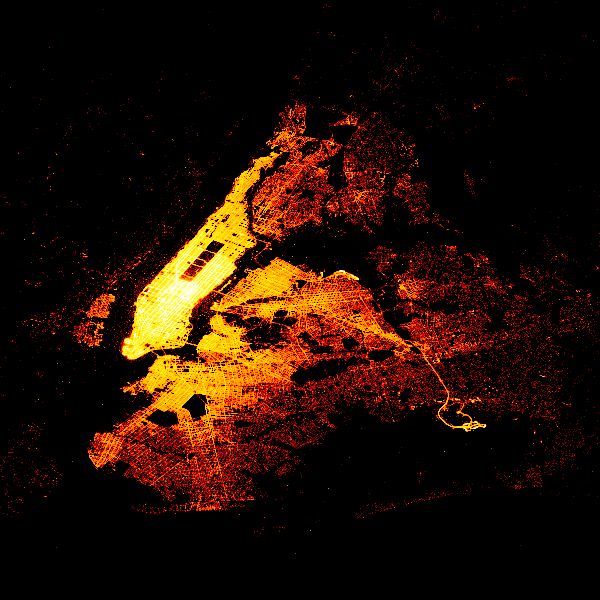

In [26]:
# Implement
agg = ds.Canvas().points(df, 'dropoff_longitude', 'dropoff_latitude')
tf.set_background(tf.shade(agg, cmap=fire),"black")

Wow, that's fast. Also it looks cool! 

Now with the holoviews. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
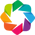

In [22]:
# Implement
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

In [23]:
%%output size=200

points = hv.Points(df, ['dropoff_longitude', 'dropoff_latitude'])
taxi_trips = datashade(points, cmap=fire)
taxi_trips

:DynamicMap   []
   :RGB   [dropoff_longitude,dropoff_latitude]   (R,G,B,A)

**Q: how many rows (data points) are we visualizing right now?**

In [27]:
# figure it out
len(df)
#data after we dropna and outliers

14751421

In [28]:
len(nyctaxi_all)
#all data of the whole dataset

14999999

We're working with ?? rows (points) right now. Yet, datashader + holoviews + bokeh renders everything almost in real time! 

## map overlays

Another useful types of visualization is overlaying data on an explorable map (Google maps, Open streetmap, ...). [Leaflet.js](https://leafletjs.com) is one of the easiest options to do that on the web, and there is a Python bridge of it: https://github.com/jupyter-widgets/ipyleaflet  Although we will not go into details, it's certainly something that's worth checking out if you're using geographical data. 